In [1]:
import torch
import pandas as pd
import numpy as np

from AIPT.Benchmarks.Liu2019_enrichment.Liu2019_data_loader import train_test_loader, encode_data, dataset_split
from AIPT.Models.Liu2019.CNNx1_regressor import CNN_regressor
from AIPT.Models.Liu2019.DNN_regressor import DNN_regressor
from AIPT.Models.Liu2019.CNNx2_regressor import CNNx2_regressor
from AIPT.Models.Liu2019.CNNx1_classifier import CNN_classifier
from AIPT.Models.Liu2019.DNN_classifier import DNN_classifier
from AIPT.Models.Liu2019.CNNx2_classifier import CNNx2_classifier

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

## prepare 4 data loaders (3 for regression + 1 for classification) 

In [6]:
traindat = pd.read_csv('cdr3s.table_Feb10.csv')
classifier_loader, regressor_loader1, regressor_loader2, regressor_loader3 = dataset_split(traindat, 
                                                                                           batch_size = 128, 
                                                                                           nd_ratio = 0.001,
                                                                                           random_seed = 10)

## ensemble model training

### model prepare
(optional, parameter set saved in ensemble_parameters.json)

In [ ]:
model_name_DNN = ['Seq_32_32']
para_dict_DNN = {'seq_len':18,
             'batch_size':100,
              'model_name':'Seq_32_32_reg',
              'epoch':80,
              'learning_rate':0.01,
              'fc_hidden_dim':32,
              'dropout_rate':0.3,
              'GPU': True}

model_name_CNN = ['Seq_32x1_16', 'Seq_64x1_16', 'Seq_32x1_16_filt3']
n_filters = [32, 64, 32]
filter_sizes = [5,5,3]
para_dict_CNN = {'batch_size':100,
             'seq_len':18,
             'epoch':80,
             'learning_rate':0.01,
             'step_size':20,
             'n_filter':32,
             'filter_size':5,
             'fc_hidden_dim':16,
             'stride':2,
             'dropout_rate': 0.3,
              'GPU': True}

model_name_CNNx2 = ['Seq_32x2_16', 'Seq_embed_32x1_16']
n_filter1s = [32, 8]
n_filter2s = [64, 32]
filter_size1s = [5,1]
filter_size2s = [5,5]
para_dict_CNNx2 = {'seq_len':18,
              'batch_size':100,
              'model_name':'Seq_32x2_16_reg',
              'epoch':80,
              'learning_rate':0.001,
              'step_size':5,
              'n_filter1':32,
              'n_filter2':64,
              'filter_size1':5,
              'filter_size2':5,
              'fc_hidden_dim':16,
              'dropout_rate':0.5,
              'GPU': True,
              'stride':1}

In [ ]:
ensemble_class_params = [para_dict_DNN.copy()] + [para_dict_CNN.copy(), para_dict_CNN.copy(), para_dict_CNN.copy()] + [para_dict_CNNx2.copy(), para_dict_CNNx2.copy()] 

# model names
model_names = model_name_DNN + model_name_CNN + model_name_CNNx2
for i in range(6):
    ensemble_class_params[i]['model_name'] = model_names[i] + '_class'
    
# filters for CNN
cnt = 0
for i in range(1, 4):
    tmp_para_dict = ensemble_class_params[i]
    tmp_para_dict['n_filters'] = n_filters[cnt]
    tmp_para_dict['filter_sizes'] = filter_sizes[cnt]
    ensemble_class_params[i] = tmp_para_dict
    cnt += 1

# filters for CNNx2
cnt = 0
for i in range(4, 6):
    ensemble_class_params[i]['n_filter1'] = n_filter1s[cnt]
    ensemble_class_params[i]['n_filter2'] = n_filter2s[cnt]
    ensemble_class_params[i]['filter_size1'] = filter_size1s[cnt]
    ensemble_class_params[i]['filter_size2'] = filter_size2s[cnt]
    cnt += 1

In [ ]:
import copy
ensemble_reg_params = copy.deepcopy(ensemble_class_params) + copy.deepcopy(ensemble_class_params) + copy.deepcopy(ensemble_class_params)

cnt = 0
for i in range(3):
    for j in range(6):
        ensemble_reg_params[cnt]['model_name'] = ensemble_reg_params[cnt]['model_name'].split('_class')[0] + '_reg' + str(i+1)
        cnt+=1      
        

In [ ]:
len(ensemble_class_params), len(ensemble_reg_params)

In [ ]:
[xx['model_name'] for xx in ensemble_reg_params]

In [ ]:
new_dict = {}
for item in ensemble_class_params:
    new_dict[item['model_name']] = item
for item in ensemble_reg_params:
    new_dict[item['model_name']] = item

In [ ]:
import json
with open('ensemble_parameters.json', 'w') as f:
    json.dump(new_dict, f, indent=2)

### hyperparam screening
(optional, previously selected params have been saved in ensemble_parameters.json)

In [ ]:
import json
para_dict_store = json.load(open('ensemble_parameters.json', 'r'))
model_architecture = ['Seq_32_32', 'Seq_32x1_16', 'Seq_64x1_16', 
                      'Seq_32x1_16_filt3', 'Seq_32x2_16', 'Seq_embed_32x1_16']
ensemble_class_params = [para_dict_store[name + '_class'] for name in model_architecture]
ensemble_reg_params = [para_dict_store[name + '_reg' + str(ii)] for ii in range(1,4) for name in model_architecture]

In [ ]:
## Hyperparameter screening for classifiers

import pdb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
#torch.cuda.set_device(1)

lr = [0.001, 0.005, 0.0005, 0.01, 0.0001]
dropout = [0.5, 0.3, 0.7]
n_epoch = 20

for k in range(len(ensemble_class_params)):
    print('--------')
    best_score = -1
    best_lr = 0
    best_dropout = 0
    current_para_dict = ensemble_class_params[k].copy()
    for i in range(len(lr)):
        current_para_dict['learning_rate'] = lr[i]
        for j in range(len(dropout)):
            current_para_dict['dropout_rate'] = dropout[j]
            current_para_dict['epoch'] = n_epoch
            if k % 6 == 0:
                test_model = DNN_classifier(current_para_dict)
            if k % 6 in [1, 2, 3]:
                test_model = CNN_classifier(current_para_dict)
            if k % 6 in [4, 5]:
                test_model = CNNx2_classifier(current_para_dict)
            
            test_model.fit(classifier_loader[0])
            print('-- Train set results --')
            output = test_model.predict(classifier_loader[0])
            labels = np.concatenate([i for _, i in classifier_loader[0]])
            mat, acc, mcc = test_model.evaluate(output, labels)
            print('-- Test set results --')
            output = test_model.predict(classifier_loader[1])
            labels = np.concatenate([i for _, i in classifier_loader[1]])
            mat, acc, mcc = test_model.evaluate(output, labels)
            if mcc > best_score:
                best_score = mcc
                best_lr = lr[i]
                best_dropout = dropout[j]
            print('Current best param: {} {}'.format(str(best_lr), str(best_dropout)))
            os.system('rm -r %s' % test_model.save_path)
    # update best parameter in the ensemble param list
    ensemble_class_params[k]['learning_rate'] = best_lr
    ensemble_class_params[k]['dropout_rate'] = best_dropout

In [ ]:
## Hyperparameter screening for regressor

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
reg_data_loaders = [regressor_loader1, regressor_loader2, regressor_loader3]
lr = [0.001, 0.005, 0.0005, 0.01, 0.0001]
dropout = [0.3, 0.5, 0.7]

for k in range(len(ensemble_reg_params)):
    best_score = 0
    best_lr = 0
    best_dropout = 0
    current_para_dict = ensemble_reg_params[k].copy()
    m = int(np.floor(k / 6.0))
    for i in range(len(lr)):
        current_para_dict['learning_rate'] = lr[i]
        for j in range(len(dropout)):
            current_para_dict['dropout_rate'] = dropout[j]
            current_para_dict['epoch'] = 5
            current_para_dict['GPU'] = True
            if k % 6 == 0:
                test_model = DNN_regressor(current_para_dict)
            if k % 6 in [1, 2, 3]:
                test_model = CNN_regressor(current_para_dict)
            if k % 6 in [4, 5]:
                test_model = CNNx2_regressor(current_para_dict)
            
            test_model.fit(reg_data_loaders[m][0])
            
            print('-- Train set results --')
            train_loader = reg_data_loaders[m][0]
            output = test_model.predict(train_loader)
            labels = np.concatenate([i for _, i in train_loader])
            r2, mse = test_model.evaluate(output, labels)
            print('-- Test set results --')
            test_loader = reg_data_loaders[m][1]
            output = test_model.predict(test_loader)
            labels = np.concatenate([i for _, i in test_loader])
            r2, mse = test_model.evaluate(output, labels)
        
            if r2 > best_score:
                best_score = r2
                best_lr = lr[i]
                best_dropout = dropout[j]
            print('Current best param: {} {}'.format(str(best_lr), str(best_dropout)))
            os.system('rm -r %s' % test_model.save_path)
            
    # update best parameter in the ensemble param list
    ensemble_reg_params[k]['learning_rate'] = best_lr
    ensemble_reg_params[k]['dropout_rate'] = best_dropout
            

In [ ]:
# save screened hyper parameters
new_dict = {}
for item in ensemble_class_params:
    new_dict[item['model_name']] = item
for item in ensemble_reg_params:
    new_dict[item['model_name']] = item
import json
with open('ensemble_parameters.json', 'w') as f:
    json.dump(new_dict, f, indent=2)

### training

In [ ]:
import json
para_dict_store = json.load(open('ensemble_parameters.json', 'r'))
model_architecture = ['Seq_32_32', 'Seq_32x1_16', 'Seq_64x1_16', 
                      'Seq_32x1_16_filt3', 'Seq_32x2_16', 'Seq_embed_32x1_16']
ensemble_class_params = [para_dict_store[name + '_class'] for name in model_architecture]
ensemble_reg_params = [para_dict_store[name + '_reg' + str(ii)] for ii in range(1,4) for name in model_architecture]

In [ ]:
## Training 6 classifiers

train_acc_store = []
test_mcc_store = []
train_mcc_store = []
test_acc_store = []
model_names_list = []

for k in range(len(ensemble_class_params)):
    current_para_dict = ensemble_class_params[k]
    print('---- Processing %s -----' % current_para_dict['model_name'])
    
    if k % 6 == 0:
        test_model = DNN_classifier(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_classifier(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_classifier(current_para_dict)
            
    test_model.fit(classifier_loader[0])
    
    print('-- Train set results --')
    output = test_model.predict(classifier_loader[0])
    labels = np.concatenate([i for _, i in classifier_loader[0]])
    mat, acc, mcc = test_model.evaluate(output, labels)
    train_acc_store.append(acc)
    train_mcc_store.append(mcc)
    print('-- Test set results --')
    output = test_model.predict(classifier_loader[1])
    labels = np.concatenate([i for _, i in classifier_loader[1]])
    mat, acc, mcc = test_model.evaluate(output, labels)
    test_acc_store.append(acc)
    test_mcc_store.append(mcc)
    model_names_list.append(current_para_dict['model_name'])

result_df = pd.DataFrame({'model_name': model_names_list,
                          'train_acc': train_acc_store, 'train_mcc': train_mcc_store,
                          'test_acc': test_acc_store, 'test_mcc': test_mcc_store})
result_df.to_csv('classifier_log_March15.csv', index=None)

In [ ]:
## Training 18 regressors

reg_data_loaders = [regressor_loader1, regressor_loader2, regressor_loader3]

train_r2_store = []
test_mse_store = []
train_mse_store = []
test_r2_store = []
model_names_list = []

for k in range(len(ensemble_reg_params)):
    current_para_dict = ensemble_reg_params[k]
    print('---- Processing %s -----' % current_para_dict['model_name'])
    
    if k % 6 == 0:
        test_model = DNN_regressor(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_regressor(current_para_dict)
    if k % 6 in [4, 5]:
        current_para_dict['stride'] = 1
        test_model = CNNx2_regressor(current_para_dict)
    
    m = int(np.floor(k / 6.0))
    test_model.fit(reg_data_loaders[m][0])
    
    print('-- Train set results --')
    output = test_model.predict(reg_data_loaders[m][0])
    labels = np.concatenate([i for _, i in reg_data_loaders[m][0]])
    r2, mse = test_model.evaluate(output, labels)
    train_r2_store.append(r2)
    train_mse_store.append(mse)
    print('-- Test set results --')
    output = test_model.predict(reg_data_loaders[m][1])
    labels = np.concatenate([i for _, i in reg_data_loaders[m][1]])
    r2, mse = test_model.evaluate(output, labels)
    test_r2_store.append(r2)
    test_mse_store.append(mse)
    
    model_names_list.append(current_para_dict['model_name'])
    
result_df = pd.DataFrame({'model_name': model_names_list,
                          'train_r2': train_r2_store, 'train_mse': train_mse_store,
                          'test_r2': test_r2_store, 'test_mse': test_mse_store})
result_df.to_csv('regressor_log_March15.csv', index=None)

### test ensemble model performance

#### regressor ensemble performances
replicating Figure 3B and 3E

In [3]:
import json
para_dict_store = json.load(open('ensemble_parameters.json', 'r'))
model_architecture = ['Seq_32_32', 'Seq_32x1_16', 'Seq_64x1_16', 
                      'Seq_32x1_16_filt3', 'Seq_32x2_16', 'Seq_embed_32x1_16']
ensemble_class_params = [para_dict_store[name + '_class'] for name in model_architecture]
ensemble_reg_params = [para_dict_store[name + '_reg' + str(ii)] for ii in range(1,4) for name in model_architecture]

In [4]:
ensemble_reg_models = []
for k in range(len(ensemble_reg_params)):
    current_para_dict = ensemble_reg_params[k]
    if k % 6 == 0:
        test_model = DNN_regressor(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_regressor(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_regressor(current_para_dict)
    test_model.net_init()    
    test_model.load_model()
    
    ensemble_reg_models.append(test_model)

In [7]:
test_loader = regressor_loader1[1]
test_mse_store = []
test_r2_store = []
y_pred = []

for k in range(len(ensemble_reg_params)):
    test_model = ensemble_reg_models[k]
    output = test_model.predict(test_loader)
    labels = np.concatenate([i for _, i in test_loader])
    r2, mse = test_model.evaluate(output, labels)
    test_r2_store.append(r2)
    test_mse_store.append(mse)
    y_pred.append(output)

R2 score = 0.489
MSE = 0.852
R2 score = 0.530
MSE = 0.784
R2 score = 0.531
MSE = 0.783
R2 score = 0.542
MSE = 0.765
R2 score = 0.412
MSE = 0.982
R2 score = 0.447
MSE = 0.922
R2 score = 0.558
MSE = 0.738
R2 score = 0.569
MSE = 0.720
R2 score = 0.553
MSE = 0.745
R2 score = 0.557
MSE = 0.739
R2 score = 0.559
MSE = 0.735
R2 score = 0.481
MSE = 0.866
R2 score = 0.547
MSE = 0.756
R2 score = 0.570
MSE = 0.718
R2 score = 0.562
MSE = 0.731
R2 score = 0.573
MSE = 0.713
R2 score = 0.647
MSE = 0.589
R2 score = 0.456
MSE = 0.908


In [8]:
y_pred_ensemble = np.mean(np.concatenate(y_pred, axis = 1), axis = 1)
r2, mse = test_model.evaluate(y_pred_ensemble, labels)
test_r2_store.append(r2)
test_mse_store.append(mse)

R2 score = 0.590
MSE = 0.684


In [9]:
performance_df = pd.DataFrame({'model': ['regressor'] *18 + ['ensemble'],
                               'R2': test_r2_store, 'mse': test_mse_store})
#performance_df.to_csv('ensemble_performance_check.csv', index = None)
performance_df.head()

,model,R2,mse
0,regressor,0.489470,0.851782
1,regressor,0.529980,0.784194
2,regressor,0.530689,0.783010
3,regressor,0.541738,0.764576
4,regressor,0.411719,0.981503


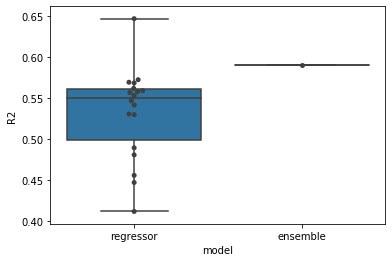

In [10]:
import seaborn as sns
%matplotlib inline
sns.boxplot(x="model", y="R2", data=performance_df)
sns.swarmplot(x="model", y="R2", data=performance_df, color=".25")

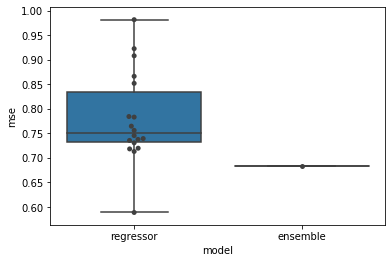

In [11]:
sns.boxplot(x="model", y="mse", data=performance_df)
sns.swarmplot(x="model", y="mse", data=performance_df, color=".25")

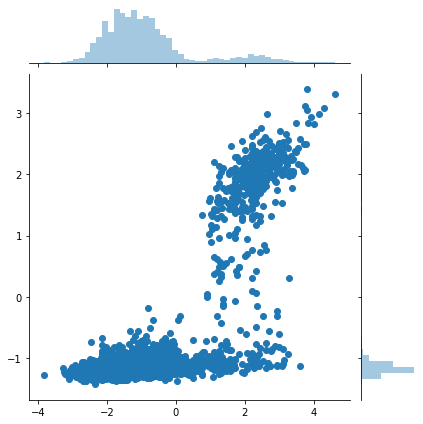

In [12]:
sns.jointplot(labels,y_pred_ensemble)

#### classifier ensemble performances
Replicating Figure 3C

In [13]:
ensemble_class_models = []
for k in range(len(ensemble_class_params)):
    current_para_dict = ensemble_class_params[k]
    if k % 6 == 0:
        test_model = DNN_classifier(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_classifier(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_classifier(current_para_dict)
        #current_param = test_model.load_param()
        #test_model = CNNx2_regressor(current_param)
    test_model.net_init()
    test_model.load_model()
    
    ensemble_class_models.append(test_model)

In [14]:
test_loader = classifier_loader[1]
x = np.concatenate([i for i, _ in test_loader], axis = 0)
y = np.concatenate([i for _, i in test_loader], axis = 0).astype(np.int64)

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
fpr_store = []
tpr_store = []
roc_auc = []

for k in range(len(ensemble_class_models)):
    y_pred_raw = ensemble_class_models[k].predict(test_loader)
    y_pred = y_pred_raw[:,1]
    fpr, tpr, _ = roc_curve(y, y_pred)
    roc_auc.append(auc(fpr, tpr))
    fpr_store.append(fpr)
    tpr_store.append(tpr)

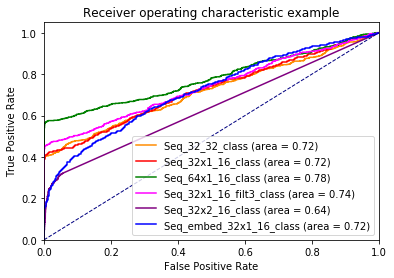

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
lw = 1.5
colors = ['darkorange','red','green','magenta','purple','blue']
for k in range(6):
    plt.plot(fpr_store[k], tpr_store[k], color=colors[k],
             lw=lw, label='%s (area = %0.2f)' % (ensemble_class_models[k].para_dict['model_name'],roc_auc[k]))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## optimization

### prepare seed sequences
either non-negative R2-to-R3 enrichment or larger than 5e-5 frequency in R3

In [ ]:
traindat = pd.read_csv('cdr3s.table_Feb10.csv')
traindat.head()

In [ ]:
seed_seqs1 = traindat.loc[traindat['log10(R3/R2)'] >= 0]
seed_seqs2 = traindat.loc[traindat['round3_freq'] >= 5e-5]

In [ ]:
import seaborn as sns
%matplotlib inline
sns.distplot(seed_seqs2['log10(R3/R2)'].values)

In [ ]:
# prepare seed seq data loader
x = seed_seqs2['cdr3'].values
X_dat = np.array([encode_data(item, gapped = False, seq_len = 18) for item in x])
y_reg = seed_seqs2['log10(R3/R2)'].to_numpy()
seed_seqs = torch.from_numpy(X_dat).float()
#seed_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_dat).float(), torch.from_numpy(y_reg).float())
#seed_loader = torch.utils.data.DataLoader(dataset=seed_dataset, batch_size=128)

### optimization

In [ ]:
import pickle
[ensemble_class_params, ensemble_reg_params] = pickle.load(open('ensemble_params_Feb24_new.p', 'rb'))

In [ ]:
step_sizes = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
intervals = [10,20,30,40,50,60,70,80]

new_seqs = []
for k in range(0, len(ensemble_class_params)):
    current_para_dict = ensemble_class_params[k]
    current_para_dict['GPU'] = False   # WHY????
    print('---- Processing %s -----' % current_para_dict['model_name'])
    if k % 6 == 0:
        test_model = DNN_classifier(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_classifier(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_classifier(current_para_dict)
    
    test_model.net_init()
    test_model.load_model()
    
    for i in range(len(step_sizes)):
        for j in range(len(intervals)):
            new_seqs.append(test_model.optimization(seed_seqs, 
                                            step_size = step_sizes[i], interval = intervals[j]))

In [ ]:
new_seqs2 = []
for k in range(5, len(ensemble_reg_params)):
    current_para_dict = ensemble_reg_params[k]
    current_para_dict['GPU'] = False
    print('---- Processing %s -----' % current_para_dict['model_name'])
    if k % 6 == 0:
        test_model = DNN_regressor(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_regressor(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_regressor(current_para_dict)
    
    test_model.net_init()
    test_model.load_model()
    
    for i in range(len(step_sizes)):
        for j in range(len(intervals)):
            new_seqs2.append(test_model.optimization(seed_seqs, 
                                            step_size = step_sizes[i], interval = intervals[j]))

In [ ]:
seq_pool = np.concatenate(new_seqs2, axis = 0)
seq_pool.shape

## Voting

### quantitative evaluation using ensemble reg models

In [ ]:
import pdb
evaluate_mat = np.zeros((seq_pool.shape[0], 18))
y = np.zeros((seq_pool.shape[0],))
seed_dataset = torch.utils.data.TensorDataset(torch.from_numpy(seq_pool).float(),torch.from_numpy(y).float())
seed_loader = torch.utils.data.DataLoader(dataset=seed_dataset, batch_size=128)

for k in range(len(ensemble_reg_params)):
    current_para_dict = ensemble_reg_params[k]
    print('---- Processing %s -----' % current_para_dict['model_name'])
    if k % 6 == 0:
        test_model = DNN_regressor(current_para_dict)
    if k % 6 in [1, 2, 3]:
        test_model = CNN_regressor(current_para_dict)
    if k % 6 in [4, 5]:
        test_model = CNNx2_regressor(current_para_dict)
    
    test_model.net_init()
    test_model.load_model()
    
    evaluate_mat[:, k] = test_model.predict(seed_loader).flatten()

In [ ]:
AA_LS = 'ACDEFGHIKLMNPQRSTVWY-'

def mat_2_seq(dat):
    seq_pos = dat.transpose().argmax(axis = 0)
    return ''.join([AA_LS[item] for item in seq_pos])

In [ ]:
aa_seq_pool = [None for _ in range(seq_pool.shape[0])]
for i in range(len(aa_seq_pool)):
    aa_seq_pool[i] = mat_2_seq(seq_pool[i,:,:])

In [ ]:
seq_eval_df = pd.DataFrame(evaluate_mat)
seq_eval_df.columns = [xx['model_name'] for xx in ensemble_reg_params]
seq_eval_df['cdr3'] = aa_seq_pool
seq_eval_df.to_csv('seq_pool_reg_Feb24.csv', index = None)

### count for top sequences
### Non-negative lower bound --> positive candidates
performed in R studio